# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step -1: Imports

In [1]:
import numpy as np
import tensorflow as tf

---
## Step 0: Load The Data

In [2]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = '../data/traffic_signs/train.p'
testing_file = '../data/traffic_signs/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
assert X_train.shape[1:] == X_test.shape[1:], 'Train and test image shapes are not the same.'


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [3]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(np.hstack((y_train, y_test))))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [78]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

def get_sample_images(img, lab):
    l, indices = np.unique(lab, return_index=True)
    return img[indices]
    
def plot_images(images, imagesToShow = 10):
    fsize = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = 32, 32
    plt.imshow(np.hstack(images[:imagesToShow]))
    plt.rcParams["figure.figsize"] = fsize

Some images from training set (double-click on the image to zoom in):

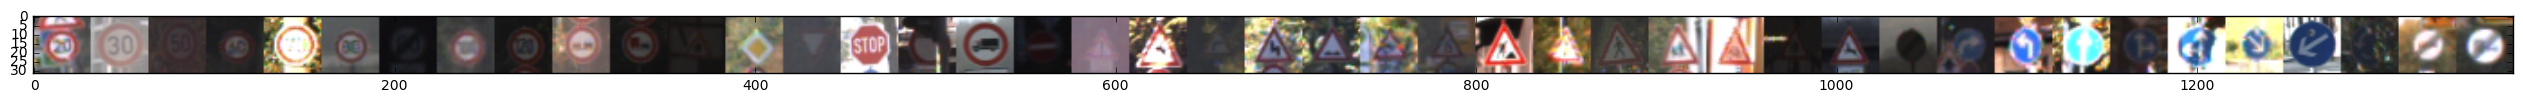

In [80]:
plot_images(get_sample_images(X_train, y_train), imagesToShow=n_classes)

And some images from test set (double-click on the image to zoom in):

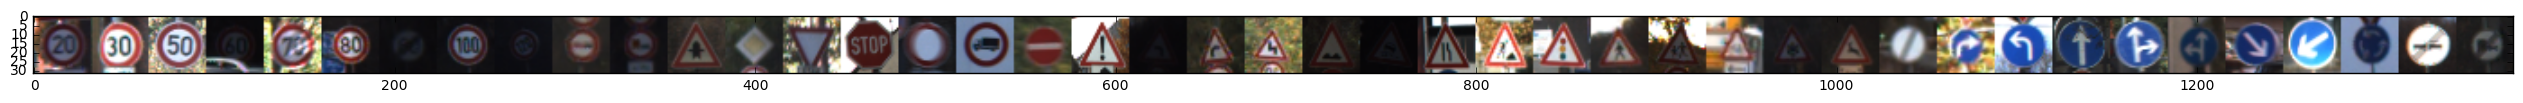

In [81]:
plot_images(get_sample_images(X_test, y_test), imagesToShow=n_classes)

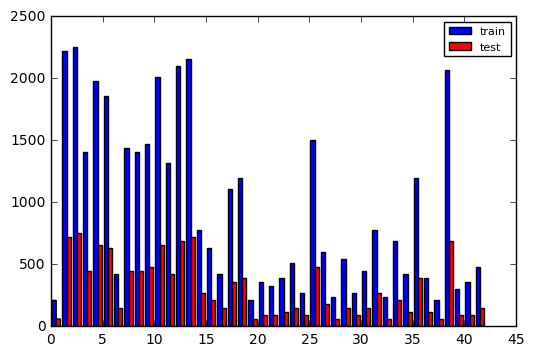

In [140]:
def plot_hist():
    fig, ax = plt.subplots()
    bins = range(0, n_classes)
    n, dst_bins, patches = ax.hist([y_train, y_test], bins, histtype='bar', color=['blue', 'red'], label=['train', 'test'])
    ax.legend(prop={'size': 8})
    plt.show()

plot_hist()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [160]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

def balance_dataset_over(images, labels):
    """
    Create balanced dataset with oversampling.
    Return list of indices to images/labels.
    """
    assert images.shape[0] == labels.shape[0]
    l, counts = np.unique(labels, return_counts=True)
    max_idx   = np.argmax(counts)
    max_count = counts[max_idx]
    print('Class {} is the largest with {} samples.'.format(max_idx, max_count))
    img_idx  = np.array([], dtype=int)
    cur_imgs = np.zeros(n_classes, dtype=int)
    for i in range(images.shape[0]):
        lab_idx   = labels[i]
        img_count = counts[lab_idx]
        assert img_count <= max_count
        # Duplicate image as needed.
        for k in range(int(np.ceil(float(max_count) / img_count))):
            if cur_imgs[lab_idx] >= max_count:
                break
            img_idx = np.append(img_idx, i)
            cur_imgs[lab_idx] += 1
    return img_idx

X_train_bal_idx_orig = balance_dataset_over(X_train, y_train)
print('Total images in balanced dataset: %d' % X_train_bal_idx_orig.shape)


Class 2 is the largest with 2250 samples.
Total images in balanced dataset: 96750


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**
At this moment, the only pre-processing that was done is balancing the dataset with oversampling. Looking at histogram of class distribution, it is clear that some classes are under-represented. There are 2 common ways to solve the problem: oversampling and undersampling. As we don't have too many images in the training set, I chose to oversample the dataset. Oversampling has to be done carefully to make sure that it actually helps in improving generalization of the model rather than just bloating the dataset without helping generalization. In my neural nets I will use an input pipeline with runtime data augmentation which means that duplicates in the balances dataset will not be just exact copies of parts of dataset.

In [163]:
### Generate additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

# Shuffle the indices.
np.random.shuffle(X_train_bal_idx_orig)

val_fraction = 0.15
n_val_bal    = int(len(X_train_bal_idx_orig) * val_fraction)

X_val_bal_idx   = X_train_bal_idx_orig[:n_val_bal]
X_train_bal_idx = X_train_bal_idx_orig[n_val_bal:]
print('Validation set size: %d' % len(X_val_bal_idx))
print('Training   set size: %d' % len(X_train_bal_idx))

Validation set size: 14512
Training   set size: 82238


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**
I've decided to split training dataset into training(85%) and validation(15%) parts.
As I mentioned in previous answer, I'm not doing any static preprocessing.

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

num_epochs = 1
batch_size = 32

def inputs():
    image  = tf.placeholder(tf.uint8, shape=[None] + list(image_shape), name='image')
    labels = tf.placeholder(tf.uint8, shape=[None],                     name='labels')
    return tf.cast(image, dtype=tf.float32), tf.cast(labels, dtype=tf.int32)

def get_train_batch():
    return {features: None, labels: None}

# Fully-connected layer
# Helper function
def _fc_layer(x, size):
    # Flatten dims for the fully-connected layer.
    x_flat = tf.reshape(x, [-1, x.get_shape()[1:].num_elements()])
    shape = [x_flat.get_shape()[1].value, size]
    W = tf.Variable(tf.truncated_normal(shape, stddev=0.01), name="weights")
    b = tf.Variable(tf.constant(0.01, shape=[shape[1]]), name="biases")
    return tf.matmul(x_flat, W) + b

# FC layer, no activation
def fc_layer(x, size, name=''):
    with tf.name_scope(name):
        return _fc_layer(x, size)
    
# FC layer with ReLU
def fc_relu_layer(x, size, name=''):
    with tf.name_scope(name) as scope:
        return tf.nn.relu(_fc_layer(x, size), name=scope)

# 2D convolutional layer with ReLU
def conv2d_relu_layer(x, kSize, mapCount=1, stride=1, name=''):
    with tf.name_scope(name) as scope:
        # assuming x is already a 4D tensor
        shape = [kSize, kSize, x.get_shape()[3].value, mapCount]
        W = tf.Variable(tf.truncated_normal(shape, stddev=0.01), name="weights")
        b = tf.Variable(tf.constant(0.01, shape=[mapCount]), name="biases")
        conv = tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='SAME', name="conv")
        return tf.nn.relu(conv + b, name=scope)

# Spatial max pooling layer
def max_pool(x, kSize, stride=0, name=''):
    if stride <= 0:
        stride = kSize
    with tf.name_scope(name):
        return tf.nn.max_pool(x, ksize=[1, kSize, kSize, 1], strides=[1, stride, stride, 1], 
                              padding='SAME', name="pool")
# Cross-entropy loss with softmax activation function
def ce_sm_loss(logits, labels):
    with tf.name_scope("loss"):
        ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits, labels, name="ce")
        return tf.reduce_mean(ce, name="ce_mean")

# Outputs (probabilities)
def probs_layer(logits):
    return tf.nn.softmax(logits)

# Training step operation
def create_train_op(loss, learning_rate, momentum):
    tf.summary.scalar(loss.op.name, loss)
    step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    return step

def simple_net(features):
    h1_size = 512
    h1 = fc_relu_layer(features, h1_size, "h1")
    h2 = fc_relu_layer(h1, h1_size, "h2")
    return h2

def conv_net_01(features):
    conv1 = conv2d_relu_layer(features, 5, 32, name='conv1')
    pool1 = max_pool(conv1, 2, name='pool1')
    conv2 = conv2d_relu_layer(pool1, 5, 32, name='conv2')
    pool2 = max_pool(conv2, 2, name='pool2')
    fc1 = fc_relu_layer(pool2, 128, 'fc1')
    return fc1

image_input, label_input = inputs()
logits = fc_layer(conv_net_01(image_input), n_classes)
probs = probs_layer(logits)
loss = ce_sm_loss(logits, label_input)
train_op = create_train_op(loss, 0.01, 0.9)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    step = 1
    for batch_start in range(0, len(X_train_bal_idx), batch_size):
        img_batch = X_train[X_train_bal_idx[batch_start:batch_start + batch_size]]
        lab_batch = y_train[X_train_bal_idx[batch_start:batch_start + batch_size]]
        _, loss_val = sess.run([train_op, loss], feed_dict={image_input: img_batch, label_input:lab_batch})
        if step % 100 == 0:
            print('Step: {}, loss: {:.4f}'.format(step, loss_val))
        step += 1
    print(loss_val)
    print('Checking validation set...')
    batch_correct = tf.reduce_sum(tf.cast(tf.nn.in_top_k(logits, label_input, 1), tf.int32))
    correct = 0
    total = 0    
    for batch_start in range(0, len(X_val_bal_idx), batch_size):
        img_batch = X_train[X_val_bal_idx[batch_start:batch_start + batch_size]]
        lab_batch = y_train[X_val_bal_idx[batch_start:batch_start + batch_size]]
        correct += np.sum(sess.run(batch_correct, feed_dict={image_input: img_batch, label_input:lab_batch}))
        total   += batch_size
        if step % 100 == 0:
            print('Step: {}, loss: {:.4f}'.format(step, loss_val))
        step += 1
    print('Total: {}, correct: {}. Accuracy: {:.3f}'.format(total, correct, float(correct) / total))
    

Step: 100, loss: 3.6144
Step: 200, loss: 2.5946
Step: 300, loss: 1.6820
Step: 400, loss: 1.8162
Step: 500, loss: 0.7303
Step: 600, loss: 0.5352
Step: 700, loss: 0.2424
Step: 800, loss: 0.2448
Step: 900, loss: 0.7764
Step: 1000, loss: 0.3309
Step: 1100, loss: 0.2688
Step: 1200, loss: 0.1524
Step: 1300, loss: 0.0342


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

def train():
    img_batch, lab_batch = train_inputs(image_list, label_list, net_type)


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.